# This Notebook includes code to generate:
1) STS Plots
2) Comparing Classification Results of Encoders Plots
3) Improvement Plots

In [5]:
# Import dependencies
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [6]:
# Fix fonts
font_files = font_manager.findSystemFonts(fontpaths=['font/'])
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Verify the font is recognized by Matplotlib
font_name = "Times New Roman"
if font_name in font_manager.get_font_names():
    print(f"'{font_name}' font successfully added.")
    # Set default font to Times New Roman
    matplotlib.rc('font', family=font_name)
else:
    print(f"'{font_name}' font not found. Please check the font installation.")

'Times New Roman' font successfully added.


In [7]:
def clean_data(data):
    mlp_acc_results = data.drop(['classfier', 'IScore', 'accuracy_list', 'kfold'], axis=1)
    mlp_acc_results['whitening'] = mlp_acc_results['whitening'].replace('', 'without whitening')
    encoder_order = ['bert', 'all-mpnet-base-v2', 'simcse', 'angle-bert', 'text-embedding-3-small', 'angle-llama', 'llama-7B', 'llama2-7B']
    mlp_acc_results['encoder'] = pd.Categorical(mlp_acc_results['encoder'], categories=encoder_order, ordered=True)
    mlp_acc_results = mlp_acc_results.sort_values(by=['dataset', 'encoder', 'whitening'])
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('text-embedding-3-small', 'ChatGPT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('bert', 'BERT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('all-mpnet-base-v2', 'SBERT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('simcse', 'SimCSE')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('llama-7B', 'LLaMA')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('llama2-7B', 'LLaMA2')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('angle-llama', 'AnglE-LLaMA')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('angle-bert', 'AnglE-BERT')
    return mlp_acc_results

In [8]:
colors = ['midnightblue', 'royalblue','midnightblue','royalblue','midnightblue','deepskyblue','powderblue']
datasets = ["mr", "cr", "subj", "mpqa", "trec", "mrpc"]
encoders = ['bert', 'all-mpnet-base-v2', 'simcse', 'angle-bert', 'ChatGPT', 'angle-llama', 'llama-7B', 'llama2-7B', 'llama3-8B']
base_path = 'https://raw.githubusercontent.com/FlockOfBird/emb-eval/main/results'

# STS

### Spearman of different whitenings

KeyError: "['classfier', 'IScore', 'accuracy_list', 'kfold'] not found in axis"

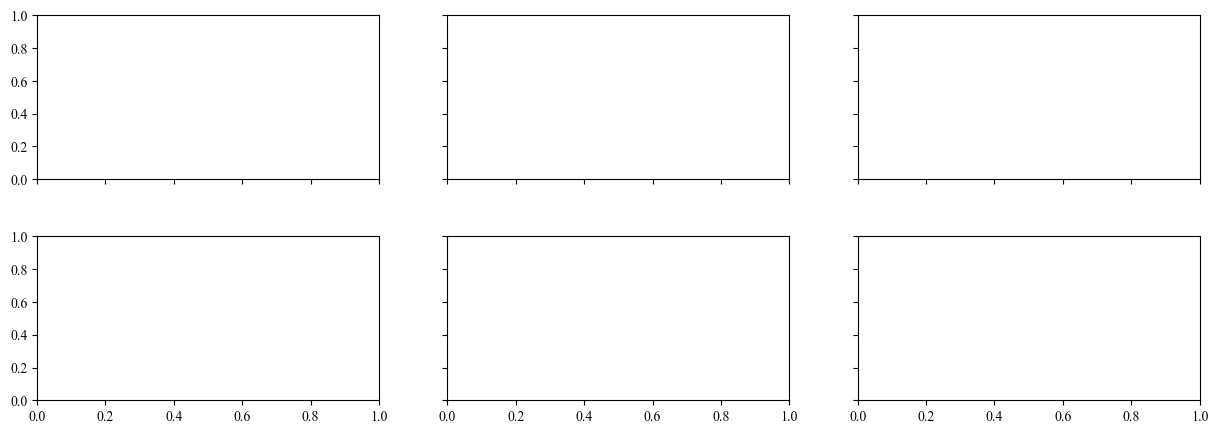

In [9]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15, 5))  # Increased the figure size for better layout
fig.subplots_adjust(hspace=0.35)  # Adjust bottom to give space for the legend
colors = ['midnightblue', 'royalblue','midnightblue','royalblue','midnightblue','deepskyblue','powderblue']
datasets = ["stsb", "sts12", "sts13", "sts14", "sts15", "sts16"]
for z, dataset in enumerate(datasets):

    data = pd.read_json(f'results/{dataset}_eval/eval_results.json')
    sts_results = clean_data(data)

    df = sts_results[sts_results['whitening'].isin(['cholesky', 'pca', 'pca-cor', 'zca'])]
    avg_df = df.groupby('encoder')['spearman_value'].mean().reset_index()
    # print(dataset)
    # print(avg_df)

    max_df = np.array(df.groupby('encoder')['spearman_value'].max())
    min_df = np.array(df.groupby('encoder')['spearman_value'].min())
    avg_df['whitening'] = 'with whitening'
    avg_df['min_spearman_value'] = min_df
    avg_df['max_spearman_value'] = max_df
    avg_df['whitening'] = 'with whitening'
    wo_df = sts_results[sts_results['whitening'].isin(['without whitening'])]
    # print(wo_df)
    sts_results = pd.concat([avg_df, wo_df], axis=0)
    c = 0
    for whitening, group in sts_results.groupby('whitening'):
        linestyle = '-' if whitening == 'without whitening' else 'dashed'
        marker = 's' if whitening == 'without whitening' else 'o'
        color = 'midnightblue' if whitening == 'without whitening' else 'royalblue'
        i, j = divmod(z, 3)
        axs[i,j].plot(group['encoder'], group['spearman_value'], label=f'{whitening}', marker=marker, linestyle=linestyle, color=color, linewidth=1)
        axs[i,j].fill_between(group['encoder'], group['min_spearman_value'], group['max_spearman_value'], color=colors[c], alpha=.15)

        c = c + 1

    c = 0
    axs[i,j].set_title(dataset.upper(), fontsize=16)
    # axs[z].set_title(dataset.upper())

    axs[i,j].grid(True, which='both', axis='y', linestyle='-', color='gray', alpha=0.1)
    # axs[z].grid(True, which='both', axis='y', linestyle='-', color='gray', alpha=0.1)

    if(i==1):
        axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=90, fontsize=12)
    # if(j==0):
    #     axs[i, j].set_ylabel('Spearman Value')
plt.grid(True, which='both', axis='y', linestyle='-', color='gray', alpha=0.1)
# plt.xticks(ha='right')
plt.legend(bbox_to_anchor=(-0.7, -0.85), loc='upper center', ncol=4, fontsize=14)  # ncol can be adjusted based on number of legends
# plt.tight_layout()
fig.subplots_adjust(bottom=0.25, left=0.05)  # You might need to adjust this value
plt.savefig('sts.pdf', format='pdf', bbox_inches='tight')
plt.show()

### distribution of cosine similarity plots

FileNotFoundError: [Errno 2] No such file or directory: 'results/sts_eval/anistropy_plots/bert.png'

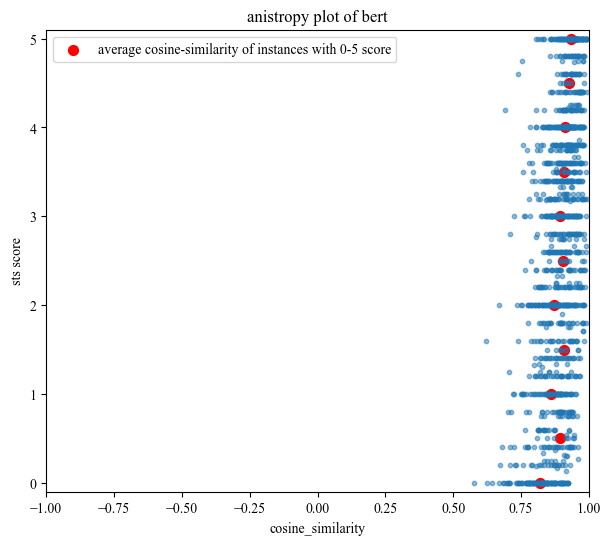

In [10]:
for encoder in encoders:
    df_scores = pd.read_csv(f'{base_path}/sts_eval/cosim/{encoder}_sts_test_cossim.csv', sep='\t').sort_values(by='score')
    # print(df_scores)
    plt.figure(figsize=(7, 6))

    for i in range (0, 12):
        current_value = i * 0.5
        filtered_df = df_scores.loc[df_scores['score'] == current_value]
        average_value = filtered_df['cos_sim'].mean()
        plt.scatter(average_value, current_value, s=50, color='red')

    plt.title(f'anistropy plot of {encoder}')
    plt.scatter(df_scores['cos_sim'], df_scores['score'], s=10, label='sts instances', alpha=0.5)
    plt.ylim(-0.1,5.1)
    plt.xlim(-1,1)
    plt.xlabel('cosine_similarity')
    plt.ylabel('sts score')
    plt.legend(['average cosine-similarity of instances with 0-5 score'])

    plt.savefig(f'results/sts_eval/anistropy_plots/{encoder}.png')
    plt.show()

### denisity of cosine similarity plots

FileNotFoundError: [Errno 2] No such file or directory: 'results/sts_eval/cosine_plots/without_whitening.png'

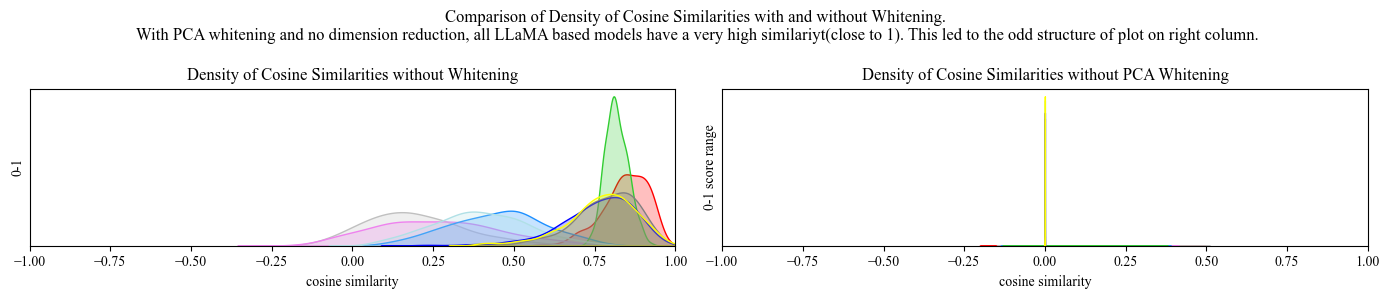

In [11]:
base_path = 'https://raw.githubusercontent.com/FlockOfBird/emb-eval/main/results'
encoders = ['bert', 'all-mpnet-base-v2', 'simcse', 'angle-bert', 'ChatGPT', 'angle-llama', 'llama-7B', 'llama2-7B', 'llama3-8B']
fig, axs = plt.subplots(1, 2, figsize=(14, 3))

colors = ['red', 'silver', 'violet', 'dodgerblue', 'limegreen','powderblue','grey','blue','yellow']
for i, encoder in enumerate(encoders):
    df_scores = pd.read_csv(f'{base_path}/sts_eval/cosim/{encoder}_sts_test_cossim.csv', sep='\t').sort_values(by='score')
    df_scores = df_scores[(df_scores['score'] < 1) & (df_scores['score'] >= 0)]
    sns.kdeplot(data=df_scores['cos_sim'], ax=axs[0], fill=True, label=encoder, color=colors[i])
    axs[0].set_title('Density of Cosine Similarities without Whitening')
    axs[0].set_ylabel('0-1')
    axs[0].set_xlim(-1, 1)
    axs[0].set_yticks([])
    axs[0].set_xlabel('cosine similarity')
    axs[0].grid(False)


for i, encoder in enumerate(encoders):
    df_scores = pd.read_csv(f'{base_path}/sts_eval/cosim/whpca-{encoder}_sts_test_cossim.csv', sep='\t').sort_values(by='score')
    df_scores = df_scores[(df_scores['score'] < 1) & (df_scores['score'] >= 0)]
    sns.kdeplot(data=df_scores['cos_sim'], ax=axs[1], fill=True, label=encoder, color=colors[i])
    axs[1].set_title('Density of Cosine Similarities without PCA Whitening')
    axs[1].set_ylabel('0-1 score range')
    axs[1].set_xlim(-1, 1)
    axs[1].set_xlabel('cosine similarity')

    axs[1].set_yticks([])
    axs[1].grid(False)

fig.suptitle('Comparison of Density of Cosine Similarities with and without Whitening.\n With PCA whitening and no dimension reduction, all LLaMA based models have a very high similariyt(close to 1). This led to the odd structure of plot on right column.')
plt.tight_layout()
plt.savefig(f'results/sts_eval/cosine_plots/without_whitening.png')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'results/sts_eval/cosine_plots/bert.png'

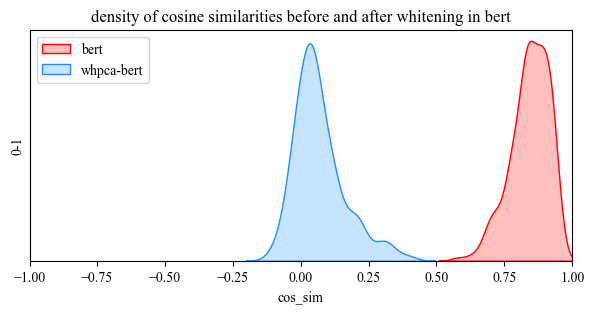

In [12]:
base_path = 'https://raw.githubusercontent.com/FlockOfBird/emb-eval/main/results'
colors = ['red', 'dodgerblue', 'silver', 'violet', 'limegreen']

for encoder in encoders:
    plt.figure(figsize=(7, 3))
    plt.title(f'density of cosine similarities before and after whitening in {encoder}')
    df_scores_now = pd.read_csv(f'{base_path}/sts_eval/cosim/{encoder}_sts_test_cossim.csv', sep='\t').sort_values(by='score')
    df_scores_now = df_scores_now[(df_scores_now['score'] < 1) & (df_scores_now['score'] >= 0)]
    sns.kdeplot(data=df_scores_now['cos_sim'], fill=True, label=encoder, color=colors[0])

    df_scores_w = pd.read_csv(f'{base_path}/sts_eval/cosim/whpca-{encoder}_sts_test_cossim.csv', sep='\t').sort_values(by='score')
    df_scores_w = df_scores_w[(df_scores_w['score'] < 1) & (df_scores_w['score'] >= 0)]
    sns.kdeplot(data=df_scores_w['cos_sim'], fill=True, label='whpca-'+encoder, color=colors[1])

    plt.ylabel('0-1')
    plt.xlim(-1,1)
    plt.yticks([])
    plt.legend(loc='upper left')
    plt.grid(False)
    plt.savefig(f'results/sts_eval/cosine_plots/{encoder}.png')
    plt.show()

# Classification Plots

### accuracy of different whitenings

#### improvement plots - one dataset

TypeError: 'value' must be an instance of str or bytes, not a float

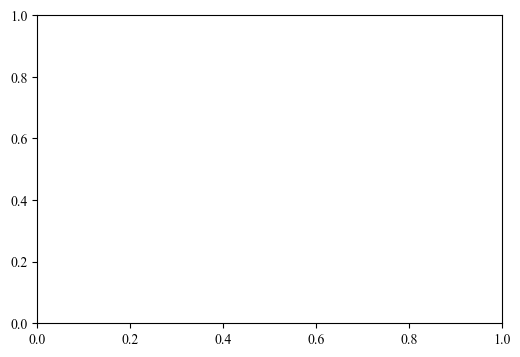

In [13]:
dataset = 'mr'
data = pd.read_json(f'https://raw.githubusercontent.com/FlockOfBird/emb-eval/main/results/{dataset}_eval/mlp_eval_results.json')
mlp_acc_results = clean_data(data)
plt.figure(figsize=(6, 4))

wo = mlp_acc_results[mlp_acc_results['whitening'] == 'w/o']
wo = np.array(wo['accuracy'].tolist())
whitening_methods = ["cholesky", "pca", "pca-cor", "zca", "zca-cor"]
results = []
c = 0
for method in whitening_methods:
    # linestyle = '-' if method == 'w/o' else 'dashed'
    # marker = 's' if method == 'w/o' else 'o'
    method_data = mlp_acc_results[mlp_acc_results['whitening'] == method]
    method_data = np.array(method_data['accuracy'].tolist())
    result = np.array([a - b for a, b in zip(method_data, wo)])
    results.append(result)
    plt.plot(mlp_acc_results['encoder'].unique(), result, label=f'{method}', marker=marker, linestyle=linestyle, color=colors[c], linewidth=0.5)

    c = c + 1
c = 0

results = np.array(results)
encoders = mlp_acc_results['encoder'].unique()
data = {
    'min': [-2.069999999999993, -2.5600000000000023, -2.2700000000000102, -1.1500000000000057, -4.75, -10.180000000000007, -10.739999999999995, -10.710000000000008],
    'max': [-2.219999999999999, -2.9799999999999898, -2.75, -1.2900000000000063, -5.349999999999994, -11.25, -11.64, -11.600000000000009],
    'encoder': ['BERT', 'SBERT', 'SimCSE', 'AnglE-BERT', 'ChatGPT', 'AnglE-LLaMA', 'LLaMA', 'LLaMA2']
}

df = pd.DataFrame(data)
plt.fill_between(df['encoder'], df['min'], df['max'], color='royalblue', alpha=.15)

plt.title(dataset.upper())
plt.grid(True, which='both', axis='y', linestyle='-', color='gray', alpha=0.1)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.24, 1.02), loc='upper right')
plt.savefig('imp.pdf', format='pdf', bbox_inches='tight')
plt.show()

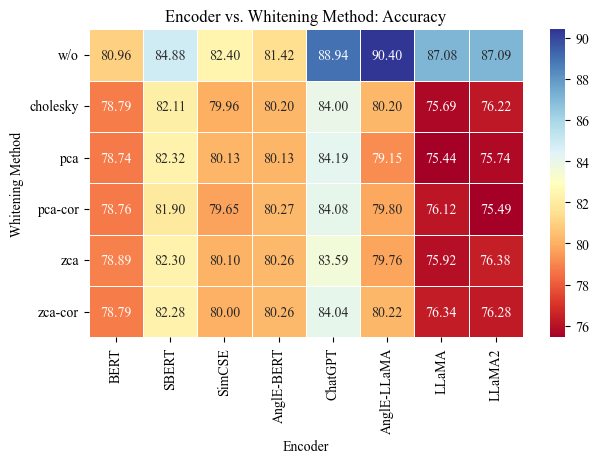

In [100]:
mlp_acc_results['whitening'] = pd.Categorical(mlp_acc_results['whitening'], categories=['w/o', 'cholesky', 'pca', 'pca-cor', 'zca', 'zca-cor'], ordered=True)
heatmap_data = pd.pivot_table(mlp_acc_results, values='accuracy', index='whitening', columns='encoder')

plt.figure(figsize=(7, 4))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=.5, cmap="RdYlBu")

plt.title('Encoder vs. Whitening Method: Accuracy')
plt.xlabel('Encoder')
plt.ylabel('Whitening Method')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## Accuracy + Improvement shaded (all)

FileNotFoundError: File results/stsb_eval/mlp_eval_results.json does not exist

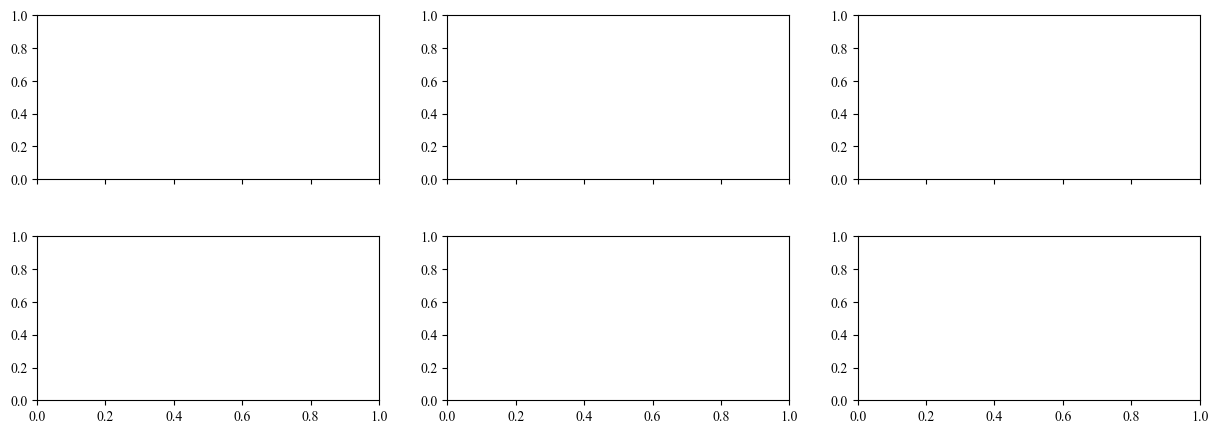

In [14]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(15, 5))
fig.subplots_adjust(hspace=0.35)
# fig.subplots_adjust(wspace=0.05)

for z, dataset in enumerate(datasets):
    data = pd.read_json(f'results/{dataset}_eval/mlp_eval_results.json')
    mlp_acc_results = clean_data(data)

    df = mlp_acc_results[mlp_acc_results['whitening'].isin(['cholesky', 'pca', 'pca-cor', 'zca'])]
    avg_df = df.groupby('encoder')['accuracy'].mean().reset_index()
    max_df = np.array(df.groupby('encoder')['accuracy'].max())
    min_df = np.array(df.groupby('encoder')['accuracy'].min())
    avg_df['whitening'] = 'with whitening'
    avg_df['dataset'] = dataset
    avg_df['min_accuracy'] = min_df
    avg_df['max_accuracy'] = max_df
    wo_df = mlp_acc_results[mlp_acc_results['whitening'].isin(['without whitening'])]

    mlp_acc_results = pd.concat([avg_df, wo_df], axis=0)
    c = 0
    for whitening, group in mlp_acc_results.groupby('whitening'):
        c = c + 1
        linestyle = '-' if whitening == 'without whitening' else 'dashed'
        marker = 's' if whitening == 'without whitening' else 'o'

        i, j = divmod(z, 3)
        axs[i, j].plot(group['encoder'], group['accuracy'], label=f'{whitening}', marker=marker, linestyle=linestyle, color=colors[c], linewidth=1)
        axs[i, j].fill_between(group['encoder'], group['min_accuracy'], group['max_accuracy'], color=colors[c], alpha=.15)

    c = 0
    axs[i,j].set_title(dataset.upper(), fontsize=16)

    axs[i,j].grid(True, which='both', axis='y', linestyle='-', color='gray', alpha=0.1)

    if(i==1):
        axs[i, j].set_xticklabels([])
        # axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=90, fontsize=12)
    # if(j==0):
    #     axs[i, j].set_ylabel('Accuracy')
# plt.legend(bbox_to_anchor=(-0.7, -0.85), loc='upper center', ncol=4, fontsize=14)  # ncol can be adjusted based on number of legends
# plt.tight_layout()
fig.subplots_adjust(bottom=0.25, left=0.05)  # You might need to adjust this value
plt.savefig('cls.pdf', format='pdf', bbox_inches='tight')

## Accuracy + Improvement shaded (single)

## Clustering

/tmp/ipykernel_982174/496624768.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wo_df['min_v_measure'] = wo_min_df
/tmp/ipykernel_982174/496624768.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wo_df['max_v_measure'] = wo_max_df
/tmp/ipykernel_982174/496624768.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

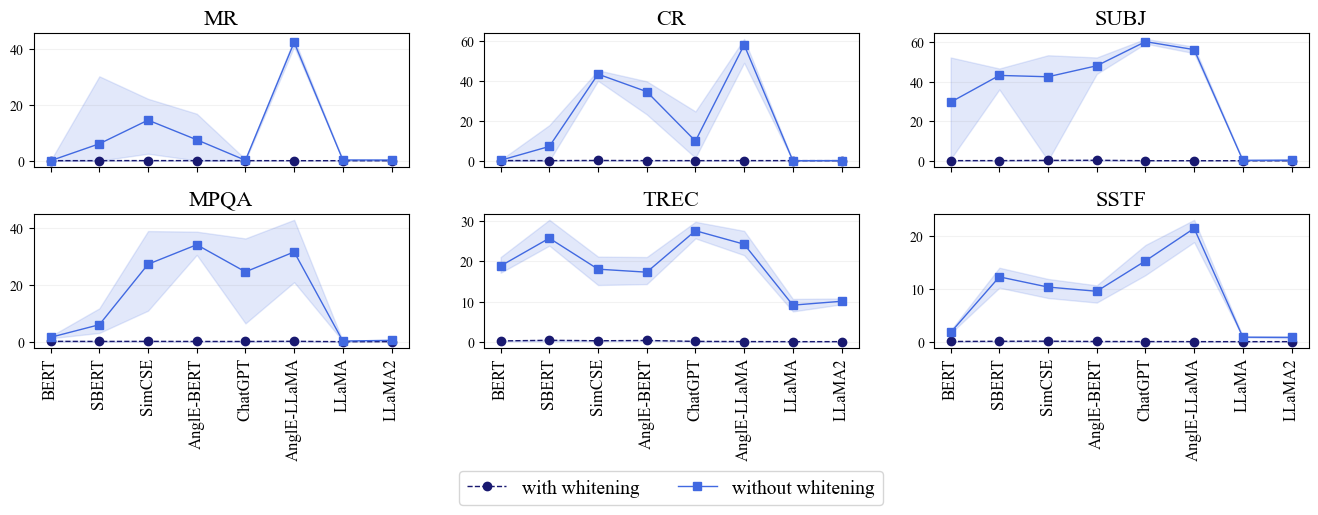

In [15]:
def clean_data(data):
    mlp_acc_results = data.drop(['clustering'], axis=1)
    mlp_acc_results['whitening'] = mlp_acc_results['whitening'].replace('', 'without whitening')
    encoder_order = ['bert', 'all-mpnet-base-v2', 'simcse', 'angle-bert', 'text-embedding-3-small', 'angle-llama', 'llama-7B', 'llama2-7B']
    mlp_acc_results['encoder'] = pd.Categorical(mlp_acc_results['encoder'], categories=encoder_order, ordered=True)
    mlp_acc_results = mlp_acc_results.sort_values(by=['dataset', 'encoder', 'whitening'])
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('text-embedding-3-small', 'ChatGPT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('bert', 'BERT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('all-mpnet-base-v2', 'SBERT')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('simcse', 'SimCSE')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('llama-7B', 'LLaMA')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('llama2-7B', 'LLaMA2')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('angle-llama', 'AnglE-LLaMA')
    mlp_acc_results['encoder'] = mlp_acc_results['encoder'].replace('angle-bert', 'AnglE-BERT')
    return mlp_acc_results

colors = ['midnightblue', 'royalblue','midnightblue','royalblue','midnightblue','deepskyblue','powderblue']
datasets = ["mr", "cr", "subj", "mpqa", "trec", "sstf"]

fig, axs = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(15, 5))
fig.subplots_adjust(hspace=0.35)
# fig.subplots_adjust(wspace=0.05)

for z, dataset in enumerate(datasets):
    data = pd.read_json(f'results/{dataset}_eval/mini_batch_k_means_eval_results_temp.json')
    mlp_acc_results = clean_data(data)
    mlp_acc_results.rename(columns={'v_measure': 'v_measure_list'}, inplace=True)
    mlp_acc_results['v_measure'] = mlp_acc_results['v_measure_list'].apply(lambda x: sum(x) / len(x))
    df = mlp_acc_results[mlp_acc_results['whitening'].isin(['cholesky', 'pca', 'pca_cor', 'zca', 'zca_cor'])]
    avg_df = df.groupby('encoder')['v_measure'].mean().reset_index()
    max_df = np.array(df.groupby('encoder')['v_measure'].max())
    min_df = np.array(df.groupby('encoder')['v_measure'].min())
    avg_df['whitening'] = 'with whitening'
    avg_df['dataset'] = dataset
    avg_df['min_v_measure'] = min_df
    avg_df['max_v_measure'] = max_df
    wo_df = mlp_acc_results[mlp_acc_results['whitening'].isin(['without whitening'])]
    wo_max_df = np.array(wo_df['v_measure_list'].apply(lambda x: max(x)))
    wo_min_df = np.array(wo_df['v_measure_list'].apply(lambda x: min(x)))
    wo_df['min_v_measure'] = wo_min_df
    wo_df['max_v_measure'] = wo_max_df
    mlp_acc_results = pd.concat([avg_df, wo_df], axis=0)
    c = 0
    for whitening, group in mlp_acc_results.groupby('whitening'):
        c = c + 1
        linestyle = '-' if whitening == 'without whitening' else 'dashed'
        marker = 's' if whitening == 'without whitening' else 'o'
        color = 'royalblue' if whitening == 'without whitening' else 'midnightblue'

        i, j = divmod(z, 3)
        axs[i, j].plot(group['encoder'], group['v_measure'], label=f'{whitening}', marker=marker, linestyle=linestyle, color=color, linewidth=1)
        axs[i, j].fill_between(group['encoder'], group['min_v_measure'], group['max_v_measure'], color=colors[1], alpha=.15)

    c = 0
    axs[i,j].set_title(dataset.upper(), fontsize=16)

    axs[i,j].grid(True, which='both', axis='y', linestyle='-', color='gray', alpha=0.1)

    if(i==1):
        axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=90, fontsize=12)
    # if(j==0):
    #     axs[i, j].set_ylabel('v_measure')

plt.legend(bbox_to_anchor=(-0.7, -0.85), loc='upper center', ncol=4, fontsize=14)  # ncol can be adjusted based on number of legends
# plt.tight_layout()
fig.subplots_adjust(bottom=0.25, left=0.05)  # You might need to adjust this value
plt.savefig('clustering.pdf', format='pdf', bbox_inches='tight')